In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

# from MD_AE_tools.models.models import *

from MD_AE_tools.models.models_no_bias import *
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_evaluation as mode_eval
import myplot

import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from contextlib import redirect_stdout

import time
import os
import configparser
import datetime
import wandb

# get system information
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']

# use gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[0], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


2022-10-04 15:24:46.237113: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 15:24:46.809264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [2]:
# data
data_file = './data/PIV4_downsampled_by8.h5'
Ntrain = 1632 # snapshots for training
Nval = 550 # sanpshots for validation
Ntest = 550

# Boolean 
LATENT_STATE = True # save latent state
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.001 #1e-05 #regulariser
drop_rate = 0.0
features_layers = [32, 64, 128]
latent_dim = 2
act_fct = 'linear'
resize_meth = 'bilinear'
filter_window= (5,5)
batch_norm = False

## training
nb_epoch = 3000
batch_size = 100
learning_rate = 0.001

Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny, Nz]

In [8]:
#============================= READ DATA FROM FILE ================================
hf = h5py.File('./data/ufluc_unshuffle_1632.h5','r')
u_all = np.array(hf.get('u_all'))
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_test = np.array(hf.get('u_test'))
u_mean_all = np.array(hf.get('u_mean_all'))
u_mean_train = np.array(hf.get('u_mean_train'))
u_mean_val = np.array(hf.get('u_mean_val'))
u_mean_test = np.array(hf.get('u_mean_test'))
hf.close()

# POD data
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod_data = md.POD(X,method='classic')
Q_POD_data,lam_data = pod_data.get_modes
Q_mean = pod_data.Q_mean
recons_data = pod_data.reconstruct(latent_dim,shape=[2,Ny,Nz,u_train.shape[1]])
recons_data = np.transpose(recons_data,[3,1,2,0])

A_data = pod_data.get_time_coefficient
pod_modes_t = []
for i in range(latent_dim):
    Q_add = pod_data.Phi[:,[i]] @ A_data[:,[i]].T
    rebuildv = np.reshape(Q_add,[2,Ny,Nz,A_data.shape[0]])
    pod_modes_t.append(rebuildv)
pod_modes_t = np.array(pod_modes_t) # [latent_dim,velocity,Ny,Nz,time]
print('MSE reconstructed with 2 POD modes',tf.keras.losses.MeanSquaredError()(u_train[0,...],recons_data).numpy())

Calculating POD ...
User has selected classic POD
POD done.
MSE reconstructed with 2 POD modes 1.4903925657272339


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


## pre-training linear

In [ ]:
## define model
mdl_linear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='linear',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)
mdl_linear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)

In [ ]:
mdl_linear.summary()

In [ ]:
hist_train = []
hist_val = []

In [ ]:
## training
pat = 200 # EarlyStopping
tempfn = './temp_pre-training-linear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

# mdl_linear.load_weights('./_experiments/pre-training-linear-unshuffle-2.h5')
# Training
hist0 = mdl_linear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train.extend(hist0.history['loss'])
hist_val.extend(hist0.history['val_loss'])

In [ ]:
plt.figure()
plt.title('linear')
plt.plot(hist_train,label='train')
plt.plot(hist_val,label='val')
plt.ylim([1.2,1.6])
# plt.xlim([1500,2000])
plt.legend()
plt.show()

In [ ]:
# mdl_linear.load_weights('temp_pre-training-linear.h5')
mdl_linear.load_weights('_experiments/pre-training-linear-unshuffle-2.h5')
print('best training loss:',mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

In [ ]:
# get ae modes from training or testing set
which = 'train'

latent_test = mdl_linear.encoder.predict(u_test[0,:,:,:,:])
latent_train = mdl_linear.encoder.predict(u_train[0,:,:,:,:])
linear_decoders = []

if which == 'train':
    z_l = latent_train
    u_in_l = u_train[0,:,:,:,:]
elif which == 'test':
    z_l = latent_test
    u_in_l = u_test[0,:,:,:,:]

for name in mdl_linear.name_decoder:
    linear_decoders.append(mdl_linear.get_layer(name))
linear_modes = []
for i in range(latent_dim):
    linear_modes.append(linear_decoders[i].predict(np.reshape(z_l[:,i],(-1,1))))
linear_modes = np.array(linear_modes)
y_test_sum = np.sum(linear_modes,axis=0)
    
y_test = mdl_linear.predict(u_in_l)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))

loss_test_1 = mdl_linear.evaluate(u_in_l,u_in_l,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in_l,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

In [ ]:
plt.figure()
for z in range(latent_dim):
    # plt.plot(latent_test[:,z],label=str(z+1))
    plt.plot(latent_train[:,z],label=str(z+1))
plt.xlim([0,600])
plt.title('latent variables')
plt.legend()
plt.show()

In [ ]:
# cov = latent_test.T@latent_test/(Ntest-1)
cov = latent_train.T@latent_train/(Ntrain-1)
# cov = np.cov(latent_test.T)
vmax = np.max(cov)
plt.figure()
plt.title('linear')
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()

sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov),' rank:',rank_var)

# compare two variables
pltz = [0,1]
plt.figure(figsize=(5,5))
plt.scatter(latent_test[:,pltz[0]],latent_test[:,pltz[1]],alpha=0.5)
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
# plt.xlim([-10,10])
# plt.ylim([-10,10])
# plt.plot([0,0.45391235],[0,0.89104634],linewidth=3,color='r')
# plt.plot([0,-0.89104634],[0,0.45391235],linewidth=3,color='r')
plt.show()
covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
sort_idx = np.argsort(covar_sum)
rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('covariance sum',rank_cov)

det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 

In [ ]:
pod_1 = md.POD(latent_train.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('linear')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(linear_decoders):
        m = linear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()
        

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('linear')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(linear_decoders):
        m = linear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

In [ ]:
for i in range(latent_dim):
    print('mse loss ae mode %i:'%(i+1),tf.keras.losses.MeanSquaredError()(u_in_l,linear_modes[i,:,:,:,:]).numpy())

## nonlinear before training

In [9]:
mdl_nonlinear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='tanh',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)

In [10]:
mdl_nonlinear.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 24, 2)]  0           []                               
                                                                                                  
 encoder (Encoder)              (None, 2)            259904      ['input_1[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                              

In [11]:
# load weights
mdl_nonlinear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)
mdl_nonlinear.load_weights('temp_pre-training-linear.h5')
# mdl_nonlinear.load_weights('_experiments/pre-training-linear-unshuffle-2.h5')
print('training loss after loading weights from linear pre-training:',mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

2022-10-04 15:29:11.988415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


training loss after loading weights from linear pre-training: 2.2773311138153076


In [ ]:
# get decoders
which = 'train'

latent_test_2 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
latent_train_2 = mdl_nonlinear.encoder.predict(u_train[0,:,:,:,:])
nonlinear_decoders = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders.append(mdl_nonlinear.get_layer(name))

nonlinear_modes = []
if which == 'train':
    for i in range(latent_dim):
        nonlinear_modes.append(nonlinear_decoders[i].predict(np.reshape(latent_train_2[:,i],(-1,1))))
elif which == 'test':
    for i in range(latent_dim):
        nonlinear_modes.append(nonlinear_decoders[i].predict(np.reshape(latent_test_2[:,i],(-1,1))))
        
nonlinear_modes = np.array(nonlinear_modes)

In [ ]:
plt.figure()
for z in range(latent_dim):
    # plt.plot(latent_test_2[:,z],label=str(z+1))
    plt.plot(latent_train_2[:,z],label=str(z+1))
plt.xlim([0,600])
plt.title('latent variables, weight loaded, not trained')
plt.legend()
plt.show()

In [ ]:
# cov_2 = latent_test_2.T@latent_test_2/(Ntest-1)
cov_2 = latent_train_2.T@latent_train_2/(Ntrain-1)
# cov_2 = np.cov(latent_test.T)
vmax = np.max(cov_2)
plt.figure()
plt.title('nonlinear before training')
plt.imshow(cov_2,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_2))
rank_var_2 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_2),' rank:',rank_var_2)

# compare two variables
pltz = [0,1]
plt.figure()
plt.scatter(latent_test_2[:,pltz[0]],latent_test_2[:,pltz[1]])
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
plt.show()

det_2 = np.linalg.det(np.corrcoef(latent_test_2.T))
print('determinant of corr matrix: ',det_2) 

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes before training')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes before training')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

plt.show()

In [ ]:
## decompose ae modes
which_decoder = 1-1
# PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_1 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_1[:15])


plt.show()

## nonlinear after training

In [12]:
hist_train_3 = []
hist_val_3 = []

In [13]:
pat = 200 # EarlyStopping
tempfn = './temp_training-nonlinear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='loss',save_best_only=True,verbose=0,save_weights_only=True)#val_loss
early_cb=EarlyStopping(monitor='loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

# mdl_nonlinear.load_weights('./temp_training-nonlinear.h5')
# Training
hist0 = mdl_nonlinear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train_3.extend(hist0.history['loss'])
hist_val_3.extend(hist0.history['val_loss'])

Epoch 1/3000
17/17 - 2s - loss: 2.0391 - val_loss: 1.7800 - 2s/epoch - 143ms/step
Epoch 2/3000
17/17 - 0s - loss: 1.8548 - val_loss: 1.7030 - 408ms/epoch - 24ms/step
Epoch 3/3000
17/17 - 0s - loss: 1.7700 - val_loss: 1.6356 - 402ms/epoch - 24ms/step
Epoch 4/3000
17/17 - 0s - loss: 1.7162 - val_loss: 1.5937 - 402ms/epoch - 24ms/step
Epoch 5/3000
17/17 - 0s - loss: 1.6794 - val_loss: 1.5678 - 404ms/epoch - 24ms/step
Epoch 6/3000
17/17 - 0s - loss: 1.6523 - val_loss: 1.5450 - 406ms/epoch - 24ms/step
Epoch 7/3000
17/17 - 0s - loss: 1.6325 - val_loss: 1.5214 - 422ms/epoch - 25ms/step
Epoch 8/3000
17/17 - 0s - loss: 1.6185 - val_loss: 1.5162 - 414ms/epoch - 24ms/step
Epoch 9/3000
17/17 - 0s - loss: 1.6104 - val_loss: 1.5065 - 414ms/epoch - 24ms/step
Epoch 10/3000
17/17 - 0s - loss: 1.6004 - val_loss: 1.4981 - 415ms/epoch - 24ms/step
Epoch 11/3000
17/17 - 0s - loss: 1.5897 - val_loss: 1.4915 - 392ms/epoch - 23ms/step
Epoch 12/3000
17/17 - 0s - loss: 1.5788 - val_loss: 1.4809 - 413ms/epoch - 2

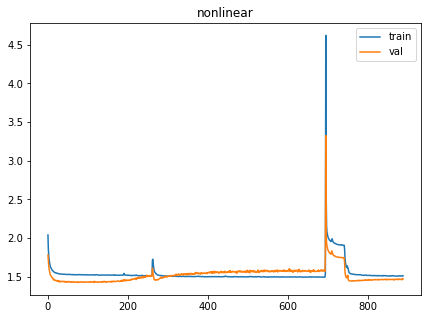

In [14]:
plt.figure(figsize=(7,5))
plt.title('nonlinear')
plt.plot(hist_train_3,label='train')
plt.plot(hist_val_3,label='val')
plt.legend()
plt.show()

In [15]:
# get ae modes from training or testing
which = 'train'


mdl_nonlinear.load_weights('./temp_training-nonlinear.h5')
latent_test_3 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
latent_train_3 = mdl_nonlinear.encoder.predict(u_train[0,:,:,:,:])
nonlinear_decoders_trained = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders_trained.append(mdl_nonlinear.get_layer(name))
nonlinear_modes_trained = []

if which == 'train':
    z = latent_train_3
    u_in = u_train[0,:,:,:,:]
elif which == 'test':
    z = latent_test_3
    u_in = u_test[0,:,:,:,:]

for i in range(latent_dim):
    nonlinear_modes_trained.append(nonlinear_decoders_trained[i].predict(np.reshape(z[:,i],(-1,1))))
nonlinear_modes_trained = np.array(nonlinear_modes_trained)
y_test_sum = np.sum(nonlinear_modes_trained,axis=0)
    
y_test = mdl_nonlinear.predict(u_in)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))
loss_test_1 = mdl_nonlinear.evaluate(u_in,u_in,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

Are results calculated the two ways the same? True
total loss: 1.4922789335250854     mse loss: 1.4587532


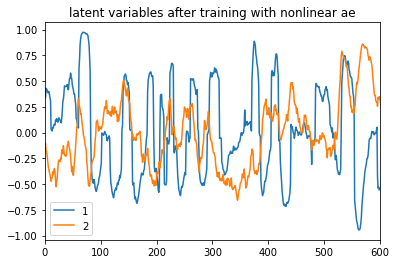

In [16]:
plt.figure()
for i in range(latent_dim):
    # plt.plot(latent_test_3[:,i],label=str(i+1))
    plt.plot(latent_train_3[:,i],label=str(i+1))
plt.xlim([0,600])
plt.title('latent variables after training with nonlinear ae')
plt.legend()
plt.show()

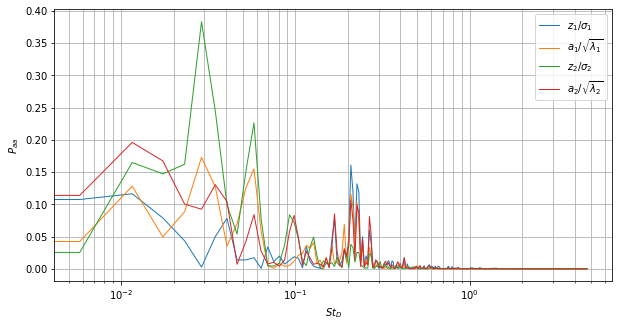

In [30]:
## get psd of latent variables
from matplotlib import mlab
plt.figure(figsize=(10,5))
for which_a in range(latent_dim):
    pxx, freqs = mlab.psd(latent_train_3[:,which_a]/(np.var(latent_train_3[:,which_a])**0.5),Fs=f_piv,NFFT=Ntrain)
    st = ((D/1000)/U_inf)*freqs
    plt.semilogx(st,pxx,label="$z_{%i}/\sigma_{%i}$"%(which_a+1,which_a+1),linewidth=1)    
    pxx, freqs = mlab.psd(A_data[:,which_a]/(lam_data[which_a]**0.5),Fs=f_piv,NFFT=Ntrain)
    plt.semilogx(st,pxx,label="$a_{%i}/\sqrt{\lambda_{%i}}$"%(which_a+1,which_a+1),linewidth=1)
plt.xlabel("$St_D$")
plt.ylabel("$P_{aa}$")
plt.grid(which='both')
plt.legend()
plt.show()

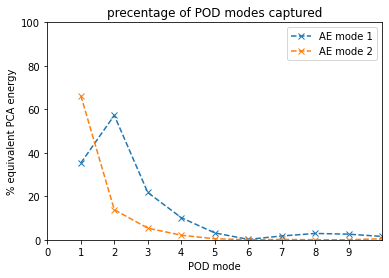

In [22]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(nonlinear_modes_trained,Q_POD_data)
lam_modes_percent = lam_modes/lam_data

x_axis = np.arange(1, Nz*Ny*Nu+1)

plt.figure()
for i in range(latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:]*100,label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.ylim([0,100])
plt.xticks(range(10))
plt.legend()
plt.xlabel('POD mode')
plt.ylabel('% equivalent PCA energy')
plt.title('precentage of POD modes captured')
plt.show()

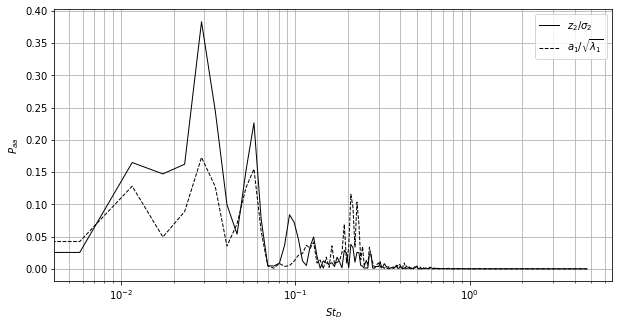

In [36]:
# compare PSD
which_z = 1
which_a = 0
plt.figure(figsize=(10,5))
# latent
pxx, freqs = mlab.psd(latent_train_3[:,which_z]/(np.var(latent_train_3[:,which_z])**0.5),Fs=f_piv,NFFT=Ntrain)
st = ((D/1000)/U_inf)*freqs
plt.semilogx(st,pxx,'k',label="$z_{%i}/\sigma_{%i}$"%(which_z+1,which_z+1),linewidth=1)
# time coeff
paa, freqs = mlab.psd(A_data[:,which_a]/(lam_data[which_a]**0.5),Fs=f_piv,NFFT=Ntrain)
plt.semilogx(st,paa,'k--',label="$a_{%i}/\sqrt{\lambda_{%i}}$"%(which_a+1,which_a+1),linewidth=1)
plt.xlabel("$St_D$")
plt.ylabel("$P_{aa}$")
plt.grid(which='both')
plt.legend()
plt.show()

In [ ]:
cov_3 = z.T@z/(z.shape[0]-1)
# cov_3 = np.cov(z.T)
vmax = np.max(cov_3)
plt.figure()
plt.title('nonlinear after training')
plt.imshow(cov_3,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_3))
rank_var_3 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_3),' rank:',rank_var_3)

# compare two variables
pltz = [0,1]
plt.figure(figsize=(5,5))
plt.scatter(z[:,pltz[0]],z[:,pltz[1]],alpha=0.5)
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.plot([0,-0.89021688],[0,-0.45553694],linewidth=3,color='k',label='new eigenvectors')
# plt.plot([0,0.45553694],[0,-0.89021688],linewidth=3,color='k')
# plt.plot([0,0.45391235],[0,0.89104634],linewidth=3,color='r',label='old eigenvectors')
# plt.plot([0,-0.89104634],[0,0.45391235],linewidth=3,color='r')
# plt.legend()
plt.show()

det_3 = np.linalg.det(np.corrcoef(z.T))
print('determinant of corr matrix: ',det_3) 

In [ ]:
pod_1 = md.POD(z.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes after training')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()
        

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes after training')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

In [ ]:
ae_modes = []
for i in range(latent_dim):
    ae_modes.append(nonlinear_decoders[i].predict(z[:,[i]]))
ae_modes = np.array(ae_modes)
fig2,ax2 = plt.subplots(1,latent_dim,sharey='all')
fig2.suptitle('modes (changing with time),v')
for i in range(latent_dim):
    im2 = ax2[i].imshow(ae_modes[i,0,:,:,0],'jet')
    div = make_axes_locatable(ax2[i])
    cax = div.append_axes('right',size='5%',pad='2%')
    plt.colorbar(im2,cax=cax)

plt.show()

In [ ]:
## decompose ae modes
which_decoder = 1-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_1 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_1[:15])


plt.show()

In [ ]:
## decompose ae modes
which_decoder = 2-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_2 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_2[:8])
plt.figure()
plt.plot(energy_1,label='1')
plt.plot(energy_2,label='2')
plt.title('spectrum')
plt.xlim([0,29])
plt.ylim([0.4,1.05])
plt.legend()

plt.show()

In [ ]:
print('mse loss ae mode 1:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[0,:,:,:,:]).numpy())
print('mse loss ae mode 2:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[1,:,:,:,:]).numpy())

## Ranking

In [ ]:
# mse loss
mse = tf.keras.losses.MeanSquaredError()
modes_E = np.copy(nonlinear_modes_trained)
rank_mse = np.zeros(latent_dim,dtype='int')-1
for j in range(latent_dim):
    E_ref = 0
    for i in range(latent_dim):
        if i not in rank_mse:
            E = 1/mse(u_in,modes_E[i]).numpy()
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = nonlinear_modes_trained + modes_E[rank_mse[j]]
rank_mse += 1

i_mse = []
for i in range(latent_dim):
    i_mse.append(mse(u_in,nonlinear_modes_trained[i,:,:,:,:]).numpy())
sort_idx = np.argsort(i_mse)
rank_i_mse = np.arange(1,latent_dim+1)[sort_idx]


ke = np.sum((nonlinear_modes_trained**2),axis=(4,3,2,1))
sort_idx = np.argsort(ke)
rank_ke = np.arange(1,latent_dim+1)[np.flip(sort_idx)]

In [ ]:
# number of POD modes to reach 99% energy u_mean_trainD modes
a = []
to99 = np.zeros(latent_dim,dtype='int')
for i in range(latent_dim):
    vy = nonlinear_modes_trained[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = nonlinear_modes_trained[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0]) #(ny,nz,nt)
    X_99 = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
    pod_99 = md.POD(X_99,method='classic')
    Q_POD_99,lam_99 = pod_99.get_modes()
    energy = np.cumsum(lam_99/np.sum(lam_99))
    a.append(energy[0])
    for j in range(len(energy)):
        if energy[j] >= 0.9999:
            to99[i] = j+1
            break
print(to99)
sort_idx = np.argsort(to99)
rank_to99 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_to99)

In [ ]:
# POD of data
vy = u_train[0,:,:,:,0] + u_mean_train[:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = u_train[0,:,:,:,1] + u_mean_train[:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy))

pod_data = md.POD(X,method='classic')
Q_POD_data,lam_data = pod_data.get_modes()
total_energy = np.sum(lam_data)

In [ ]:
# linear energy
a = []
lam_modes = []
for i in range(latent_dim):
    vy = nonlinear_modes_trained[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = nonlinear_modes_trained[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0])
    X_mode = np.vstack((vz,vy))
    nt = X_mode.shape[-1]
    X_mode = np.reshape(X_mode,(-1,nt))
    A = X_mode.T @ Q_POD_data #(nt,nx)
    lam_1 = np.sum(np.square(A),axis=0)/(nt-1)
    lam_modes.append(lam_1)

lam_modes = np.array(lam_modes)

In [ ]:
plt.figure(figsize=(10,5))
for i in range(latent_dim):
    plt.plot(lam_modes[i,:],label=i+1,linestyle='none',marker='x')
plt.plot(lam_data,label='data')
plt.xlim([-1,20])
plt.ylim(bottom=0)
plt.legend()

In [ ]:
## sum of square of elements in a ae mode
for i in range(latent_dim):
    m = nonlinear_decoders_trained[i].predict(np.reshape(1,(1,1)))
    ke = np.sum(m[0,:,:,:]**2)
    print(ke/2933)

In [ ]:
print('rank_variance:       ',rank_var_3)
print('rank_mse:            ',rank_mse)
print('rank_i_mse:          ',rank_i_mse)
print('rank_to99:           ',rank_to99)
print('rank_ke:             ',rank_ke)

In [ ]:
rank_var

In [ ]:
### save to wandb
config_wandb = {'latent_dim':latent_dim}
run = wandb.init(config=config_wandb,project="MD-CNN-AE",group='experiments',name='2-mode')
with run:
    for i in range(1008):
        run.log({"pod1":lam_modes[rank_var[0]-1,i]/np.max(lam_modes[rank_var[0]-1,:]),"pod2":lam_modes[rank_var[1]-1,i]/np.max(lam_modes[rank_var[1]-1,:])})